In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [66]:
import re

import numpy as np
import tensorflow as tf
from transformers import pipeline
import torch

from summarizer import bpe_summarize, sentencizer
from summarizer.validation import scicummnet_validation, rouge_metric, similarity_score, mean_rouge_fscore

In [67]:
validation_set = scicummnet_validation("../summarizer/validation/data/scisummnet_release1.1__20190413/")

In [68]:
random_sample = validation_set[np.random.randint(0, len(validation_set))]
assert random_sample is not None

In [69]:
sample_text, human_summary = random_sample
human_summary

'Local Phrase Reordering Models For Statistical Machine Translation\nWe describe stochastic models of local phrase movement that can be incorporated into a Statistical Machine Translation (SMT) system.\nThese models provide properly formulated, non-deficient, probability distributions over reordered phrase sequences.\nThey are implemented by Weighted Finite State Transducers.\nWe describe EM-style parameter re-estimation procedures based on phrase alignment under the complete translation model incorporating reordering.\nOur experiments show that the reordering model yields substantial improvements in translation performance on Arabic-to-English and Chinese-to-English MT tasks.\nWe also show that the procedure scales as the bitext size is increased.\nWe present a polynomial-time strategy.\nWe define two local reordering models for their Translation Template Model (TTM): In the first one, called MJ-1, only adjacent phrases are allowed to swap, and the movement has to be done within a win

In [70]:
bpe_summary = bpe_summarize(sample_text[:1024], percentile=99)
bpe_summary = re.sub(r"\n|\s{2,99}", "", bpe_summary)
bpe_summary

'\tLocal Phrase Reordering Models For Statistical Machine TranslationWe describe stochastic models of localphrase movement that can be incorporated into a Statistical Machine Translation (SMT) system.'

In [71]:
mean_rouge_fscore(bpe_summary, human_summary)

0.2804878022940215

In [72]:
similarity_score(bpe_summary, human_summary)

-0.546875

In [73]:
from transformers import BartTokenizer

# stripped down pipeline to only summarization task
# https://github.com/huggingface/transformers/blob/70bc3ead4f0b08e8cadd1805ada2a22f0c302399/src/transformers/pipelines.py#L1476

def bart_summarizer(text):
    bart_tokenizer: BartTokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
    bart_tokens = bart_tokenizer.encode(text)
    return bart_tokenizer.decode(bart_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=True,)

In [74]:
bart_summary = bart_summarizer(sample_text[:1024])
bart_summary

'\n\tLocal Phrase Reordering Models For Statistical Machine Translation\n\t\tWe describe stochastic models of localphrase movement that can be incorporated into a Statistical Machine Translation (SMT) system.\n\t\tThese models pro vide properly formulated, non-deficient, probability distributions over reorderedphrase sequences.\n\t\tThey are implemented by Weighted Finite State Trans ducers.\n\t\tWe describe EM-style parameter re-estimation procedures based on phrase alignment under the complete translationmodel incorporating reordering.\n\t\tOur ex periments show that the reordering modelyields substantial improvements in trans lation performance on Arabic-to-English and Chinese-to-English MT tasks.\n\t\tWe also show that the procedure scales as the bitext size is increased.\n\t\n\t\n\t\t\tWord and Phrase Reordering is a crucial component of Statistical Machine Translation (SMT) systems.However allowing reordering in translation is computationally expensive and in some cases even prov

In [75]:
mean_rouge_fscore(bart_summary, human_summary)

0.6666666616710563

In [76]:
similarity_score(bart_summary, human_summary)

-0.71875

In [77]:
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [78]:
sample_size = 100

In [79]:
bart_scores = []
bart_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bart_summary = bart_summarizer(sample_text[:1024])
    bart_summaries.append(bart_summary)
    bart_scores.append(similarity_score(bart_summary, human_summary))

100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


In [80]:
np.mean(bart_scores)

-0.6517462

In [81]:
bpe_scores = []
bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70)
    bpe_summary = re.sub(r"\s{2,99}", "", bpe_summary)
    bpe_summaries.append(bpe_summary)
    bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:01<00:00, 79.09it/s]


In [82]:
np.mean(bpe_scores)

-0.5665855

(0.0, -1.0)

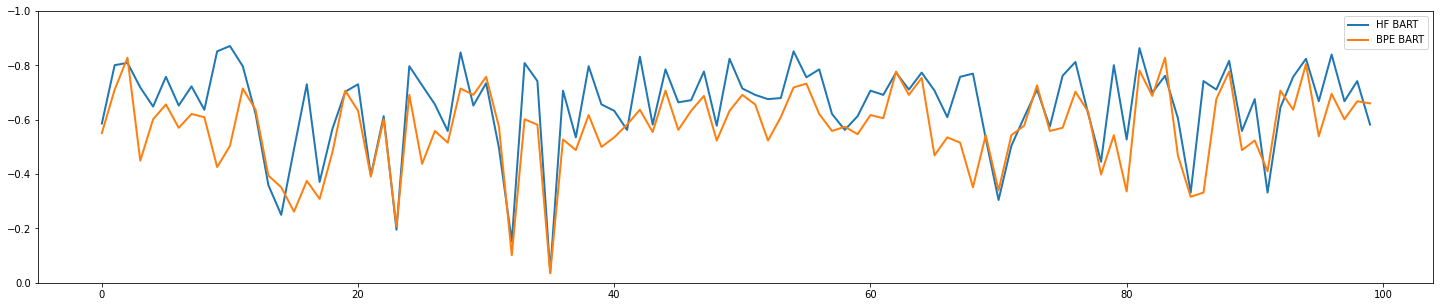

In [92]:
%matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='HF BART')
ax.plot(np.array(bpe_scores), linewidth=2, label='BPE BART')
ax.legend()

plt.ylim(0,-1)

In [84]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bpe_scores)
print(best_bpe)
best = bpe_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.828125


'Optimizing Chinese Word Segmentation for Machine Translation Performance\nPrevious work has shown that Chinese word segmentation is useful for machine translation to English, yet the way different segmentation strategies affect MT is still poorly understood.\nIn this paper, we demonstrate that optimizing segmentation for an existing segmentation standard does not always yield better MT performance.\nWe find that other factors such as segmentation consistency and granularity of Chinese “words” can be more important for machine translation.\nBased on these findings, we implement methods inside a conditional random field segmenter that directly optimize segmentation granularity with respect to the MT task, providing an improvement of 0.73 BLEU.\nWe also show that improving segmentation consistency using external lexicon and proper noun features yields a 0.32 BLEU increase.\nWe develop the CRF-based Stanford Chinese segmenter that is trained on the segmentation of the Chinese Treebank for

In [85]:
bpe_summaries[best]

'Optimizing Chinese Word Segmentation for Machine Translation PerformancePrevious work has shown that Chinese word segmentation is useful for machine translation to English, yet the way different segmentation strategies affect MT is still poorly understood. We find that other factors such as segmentation consistency and granularity of Chinese &#8220;words&#8221; can be more important for machine translation. Based on these findings, we implement methods inside a conditional random field segmenter that directly optimize segmentation granularity with respect to the MT task, providing an improvement of 0.73 BLEU. We also show that improving segmentation consistency using external lexicon and proper noun features yields a 0.32 BLEU increase.'

In [86]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bart_scores)
print(best_bpe)
best = bart_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.87109375


'Mildly Non-Projective Dependency Structures\nSyntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\nIn dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\nWhile projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\nIn this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\nThe results indicate that a combination of the well-nestedness constraint and a parametric con

In [87]:
bart_summaries[best]

'\n  Mildly Non-Projective Dependency Structures\n  \n    Syntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\n    In dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\n    While projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\n    In this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\n    The results indicate that a combination of the well-nestedness con

In [88]:
t,human = validation_set[:sample_size][best]
result = bpe_summarize(t[:1024], percentile=70)
re.sub(r"\n|\s{2,99}", "", result)
t

'\n  Mildly Non-Projective Dependency Structures\n  \n    Syntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\n    In dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\n    While projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\n    In this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\n    The results indicate that a combination of the well-nestedness con

In [89]:
blob = "The most meaningful part of this sentence is here. I frost apples. Kung fu."
result = bpe_summarize(blob)
result

'The most meaningful part of this sentence is here.'

In [90]:
blob = "The most meaningful part of this sentence is here. I frost apples. Kung fu."
result = bart_summarizer(blob)
result

' The most meaningful part of this sentence is here. I frost apples. Kung fu.'